# Energy Aspects wick_airport_wick_airport_data Analyst case study
You are a data analyst at Energy Aspects. <br>
The gas team needs a model to help them understand gas demand in Northern Scotland. <br>
They believe Gas demand is tied up to temperatures and tasked you to forecast minimum temperatures in the next 24 months.<br>
For this exercise, you will use weather data from Wick Airport as a proxy for Northern Scotland weather.<br>
The language to be used is Python.<br>
You can use any library you may find useful for the task.<br>

### Case study assessment
- Do not overcomplexify your answers. We value our team's ability to give simple answers to simple questions
- Focus on clean code and short, high level explainations of choices
- Do not spend time tuning models to get accurate results. We will not assess you on model accuracy / tuning
- We will assess relevance of analytics, visualisations, model choice and reasonings

## Data source and description

wick_airport_weather_data.csv<br>
https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data<br>

Wick Airport<br>
Location  336500E 952200N, Lat 58.454 Lon -3.088, 36m amsl<br>
Estimated data is marked with a * after the value.<br>
Missing data (more than 2 days missing in month) is marked by  ---.<br>
Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine data taken from a Campbell Stokes recorder.<br>
- Mean daily maximum temperature (tmax): degC
- Mean daily minimum temperature (tmin): degC
- Days of air frost (af): days
- Total rainfall (rain): mm
- Total sunshine duration (sun): hours

# Import data
Import data from data/wick_airport_weather_data.csv

In [96]:
import pandas as pd
import numpy as np

wick_airport_data_file_path = "data/wick_airport_weather_data.csv"
wick_airport_data = pd.read_csv(wick_airport_data_file_path)

# Extract and transform
Make all the cleaning and transformation steps you judge necessary to analyse the data

In [97]:
def generate_data_cleanliness_stats(df):
    # Check for missing values and provide a summary of the dataset
    print(df.info(), df.isna().sum())


def clean_data(df):
    def process_estimated_data(df, columns_to_check):       
        for col in columns_to_check:            
            # Remove the asterisk and convert column to numeric type
            if df[col].dtype == object:
                df[col] = pd.to_numeric(df[col].str.replace('*', ''), errors='coerce')

        return df
    
    def interpolate_column(df, column, method):
        if df[column].isnull().any():
            df[column] = df[column].interpolate(method)

        return df

    # Drop columns with excessive missing data or that are not needed
    columns_to_drop = ['sun', 'status']
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

    # Columns that may contain estimated values
    columns_to_check = ['tmax', 'tmin', 'rain']
    df = process_estimated_data(df, columns_to_check)

    # Replace placeholders like '---' with NaN and convert temperature readings from strings to floats, if not already done
    columns_to_convert = ['tmax', 'tmin', 'af', 'rain']
    replace_placeholders_with_NaN(df, columns_to_convert)

    # Convert the 'yyyy' and 'mm' columns into a single datetime column representing the first day of each month
    if "date" not in df.columns:
        df['date'] = pd.to_datetime(df['yyyy'].astype(str) + '-' + df['mm'].astype(str) + '-01')
        df.set_index('date', inplace=True)

    # Fill missing temperature values using interpolation
    df = interpolate_column(df, "tmin", "time")
    df = interpolate_column(df, "tmax", "time")
        
    return df

def replace_placeholders_with_NaN(df, columns_to_convert):
    for column in columns_to_convert:
        if df[column].dtype == object:
            df[column] = df[column].replace('---', np.nan).apply(pd.to_numeric, errors='coerce')


def check_data_integrity(df):
    """
    Checks the integrity of weather data for potentially erroneous entries.
    This function prints out rows that contain values outside typical ranges for temperature and rainfall.
    
    Args:
    df: df containing weather data with columns for 'tmax', 'tmin', and 'rain'.
    """
    # Define reasonable ranges for temperature and rainfall
    temp_range = (-30, 35)
    rain_range = (0, 1000)

    # Identify outliers
    temp_outliers = df[~df['tmax'].between(*temp_range) | ~df['tmin'].between(*temp_range)]
    rain_outliers = df[~df['rain'].between(*rain_range)]
    
    # Print potentially erroneous data
    if not temp_outliers.empty:
        print("Potential temperature errors found:")
        print(temp_outliers[['tmax', 'tmin']])
    
    if not rain_outliers.empty:
        print("Potential rainfall errors found:")
        print(rain_outliers['rain'])

generate_data_cleanliness_stats(wick_airport_data)
wick_airport_data = clean_data(wick_airport_data)
generate_data_cleanliness_stats(wick_airport_data)

check_data_integrity(wick_airport_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   yyyy    1302 non-null   int64 
 1   mm      1302 non-null   int64 
 2   tmax    1302 non-null   object
 3   tmin    1302 non-null   object
 4   af      1302 non-null   object
 5   rain    1302 non-null   object
 6   sun     1302 non-null   object
 7   status  6 non-null      object
dtypes: int64(2), object(6)
memory usage: 81.5+ KB
None yyyy         0
mm           0
tmax         0
tmin         0
af           0
rain         0
sun          0
status    1296
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1302 entries, 1914-01-01 to 2022-06-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yyyy    1302 non-null   int64  
 1   mm      1302 non-null   int64  
 2   tmax    1302 non-null   float64
 3   tmin    1302 non-null   float64

# Data exploration and charting
Perform Exploratory Data Analysis on the dataset.<br>
Present your findings in a few lines and charts.

              yyyy           mm         tmax         tmin           af  \
count  1302.000000  1302.000000  1302.000000  1302.000000  1096.000000   
mean   1967.751152     6.486175    10.506198     5.026482     3.571168   
std      31.333953     3.453351     3.685052     3.405321     4.653515   
min    1914.000000     1.000000     2.200000    -2.900000     0.000000   
25%    1941.000000     3.000000     7.300000     2.225000     0.000000   
50%    1968.000000     6.000000    10.200000     4.550000     1.000000   
75%    1995.000000     9.000000    13.800000     8.100000     6.000000   
max    2022.000000    12.000000    18.600000    12.000000    25.000000   

              rain        month  
count  1302.000000  1302.000000  
mean     64.914055     6.486175  
std      30.133000     3.453351  
min       1.400000     1.000000  
25%      42.800000     3.000000  
50%      61.800000     6.000000  
75%      84.175000     9.000000  
max     234.600000    12.000000  


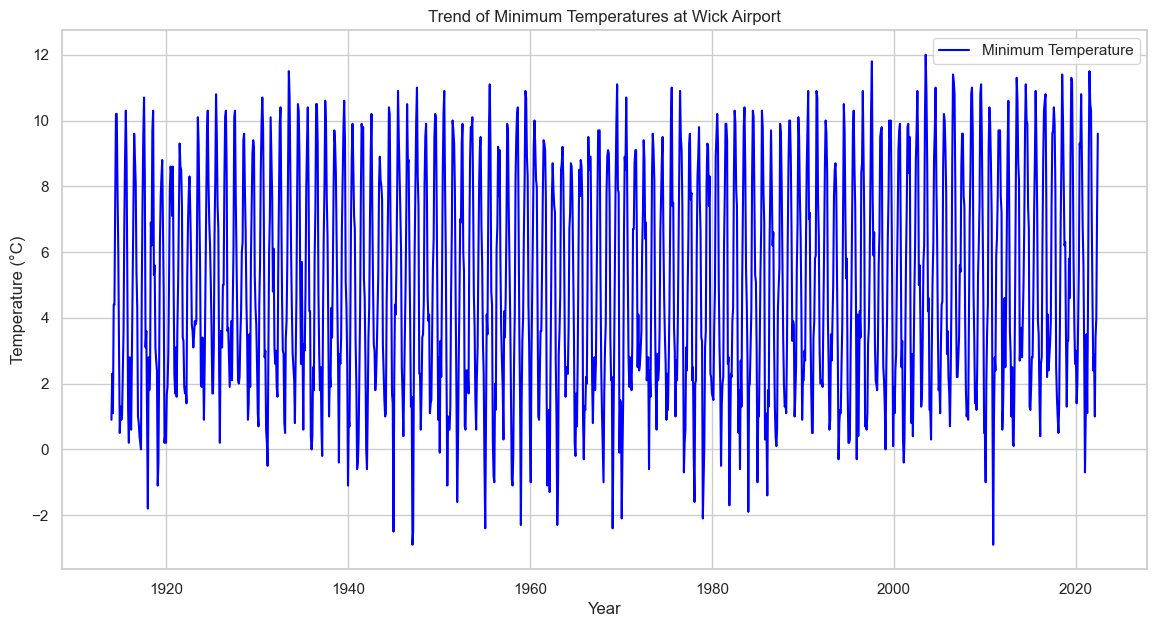

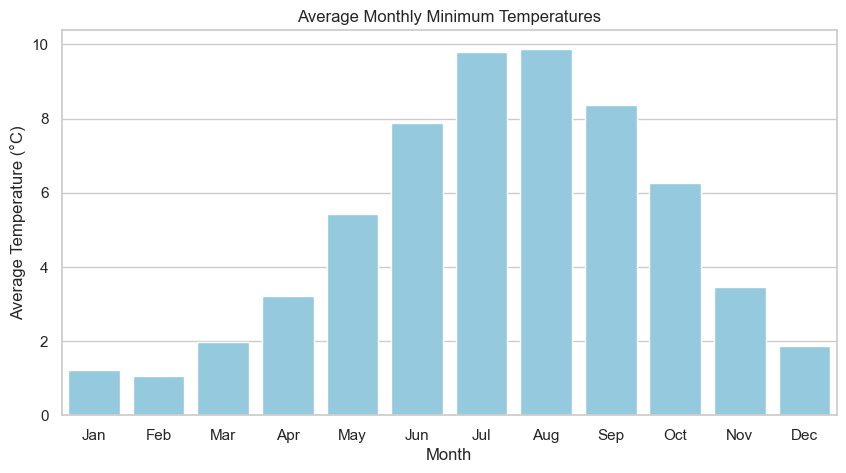

Stationary Test (Minimum Temperature):
ADF Statistic: -4.639354
p-value: 0.000109
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
              yyyy           mm         tmax         tmin           af  \
count  1302.000000  1302.000000  1302.000000  1302.000000  1096.000000   
mean   1967.751152     6.486175    10.506198     5.026482     3.571168   
std      31.333953     3.453351     3.685052     3.405321     4.653515   
min    1914.000000     1.000000     2.200000    -2.900000     0.000000   
25%    1941.000000     3.000000     7.300000     2.225000     0.000000   
50%    1968.000000     6.000000    10.200000     4.550000     1.000000   
75%    1995.000000     9.000000    13.800000     8.100000     6.000000   
max    2022.000000    12.000000    18.600000    12.000000    25.000000   

              rain        month  
count  1302.000000  1302.000000  
mean     64.914055     6.486175  
std      30.133000     3.453351  
min       1.400000     1.000000  
25%      42.800000     3.00

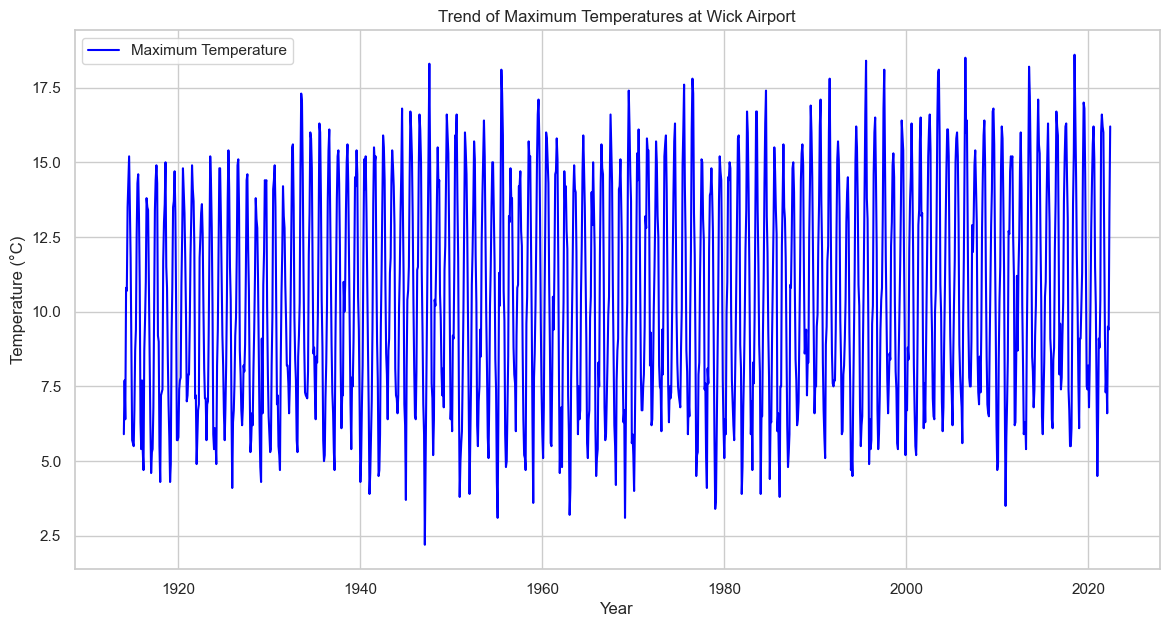

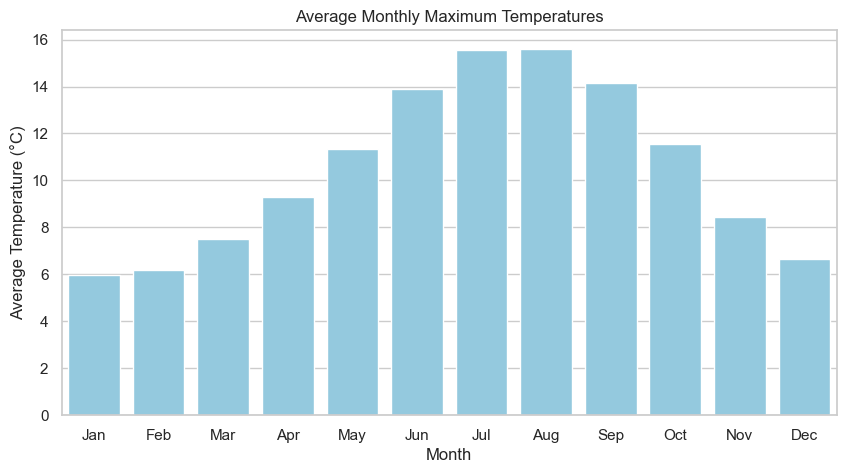

Stationary Test (Maximum Temperature):
ADF Statistic: -3.606734
p-value: 0.005634
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Set visual style for plots
sns.set(style="whitegrid")

column_name_taxonomy = {
    "tmin": "Minimum Temperature",
    "tmax": "Maximum Temperature",
}

# Descriptive statistics for the data
def run_exploratory_data_analysis(column_name):
    def descriptive_stats(df):
        descriptive_stats = df.describe()
        print(descriptive_stats)

    def plot_min_temps(df):
        # Plotting the trend of minimum temperatures over time
        plt.figure(figsize=(14, 7))
        plt.plot(df.index, df[column_name], label=f'{column_name_taxonomy[column_name]}', color='blue')
        plt.title(f'Trend of {column_name_taxonomy[column_name]}s at Wick Airport')
        plt.xlabel('Year')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.show()
        return descriptive_stats

    def plot_seasonality(df):
        # Create a column for month to facilitate monthly analysis
        df['month'] = df.index.month

        # Plotting monthly averages of minimum temperatures to observe seasonality
        monthly = df.groupby('month')[column_name].mean()

        plt.figure(figsize=(10, 5))
        sns.barplot(x=monthly.index, y=monthly.values, color='skyblue')
        plt.title(f'Average Monthly {column_name_taxonomy[column_name]}s')
        plt.xlabel('Month')
        plt.ylabel('Average Temperature (°C)')
        plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.show()

    # Function to test stationarity
    def test_stationarity(timeseries):
        result = adfuller(timeseries.dropna())  # Dickey-Fuller test
        print(f"Stationary Test ({column_name_taxonomy[column_name]}):")
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

    descriptive_stats(wick_airport_data)
    plot_min_temps(wick_airport_data)
    plot_seasonality(wick_airport_data)
    test_stationarity(wick_airport_data[column_name])


run_exploratory_data_analysis("tmin")
run_exploratory_data_analysis("tmax")


# Modelling
Choose a model, backtest it and generate forecasts for the 24 months ahead.<br>
Explain your model choice in a few lines and present backtesting / forecasting results using tables and charts understandable for analysts who do not write code or build statistical models.


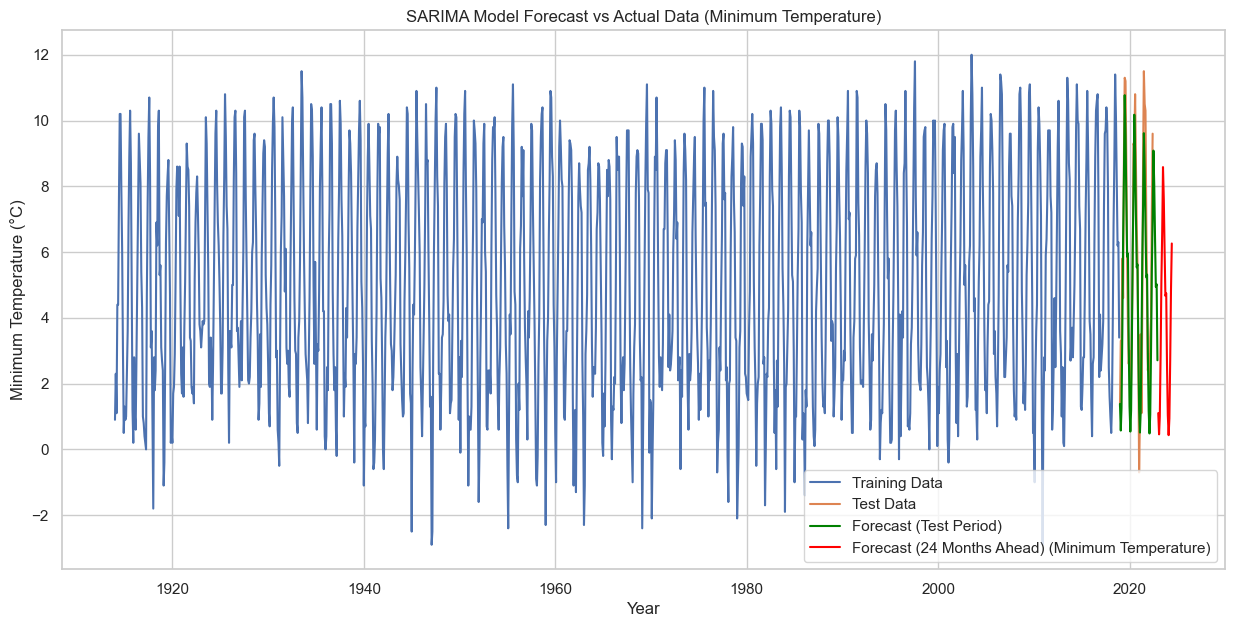

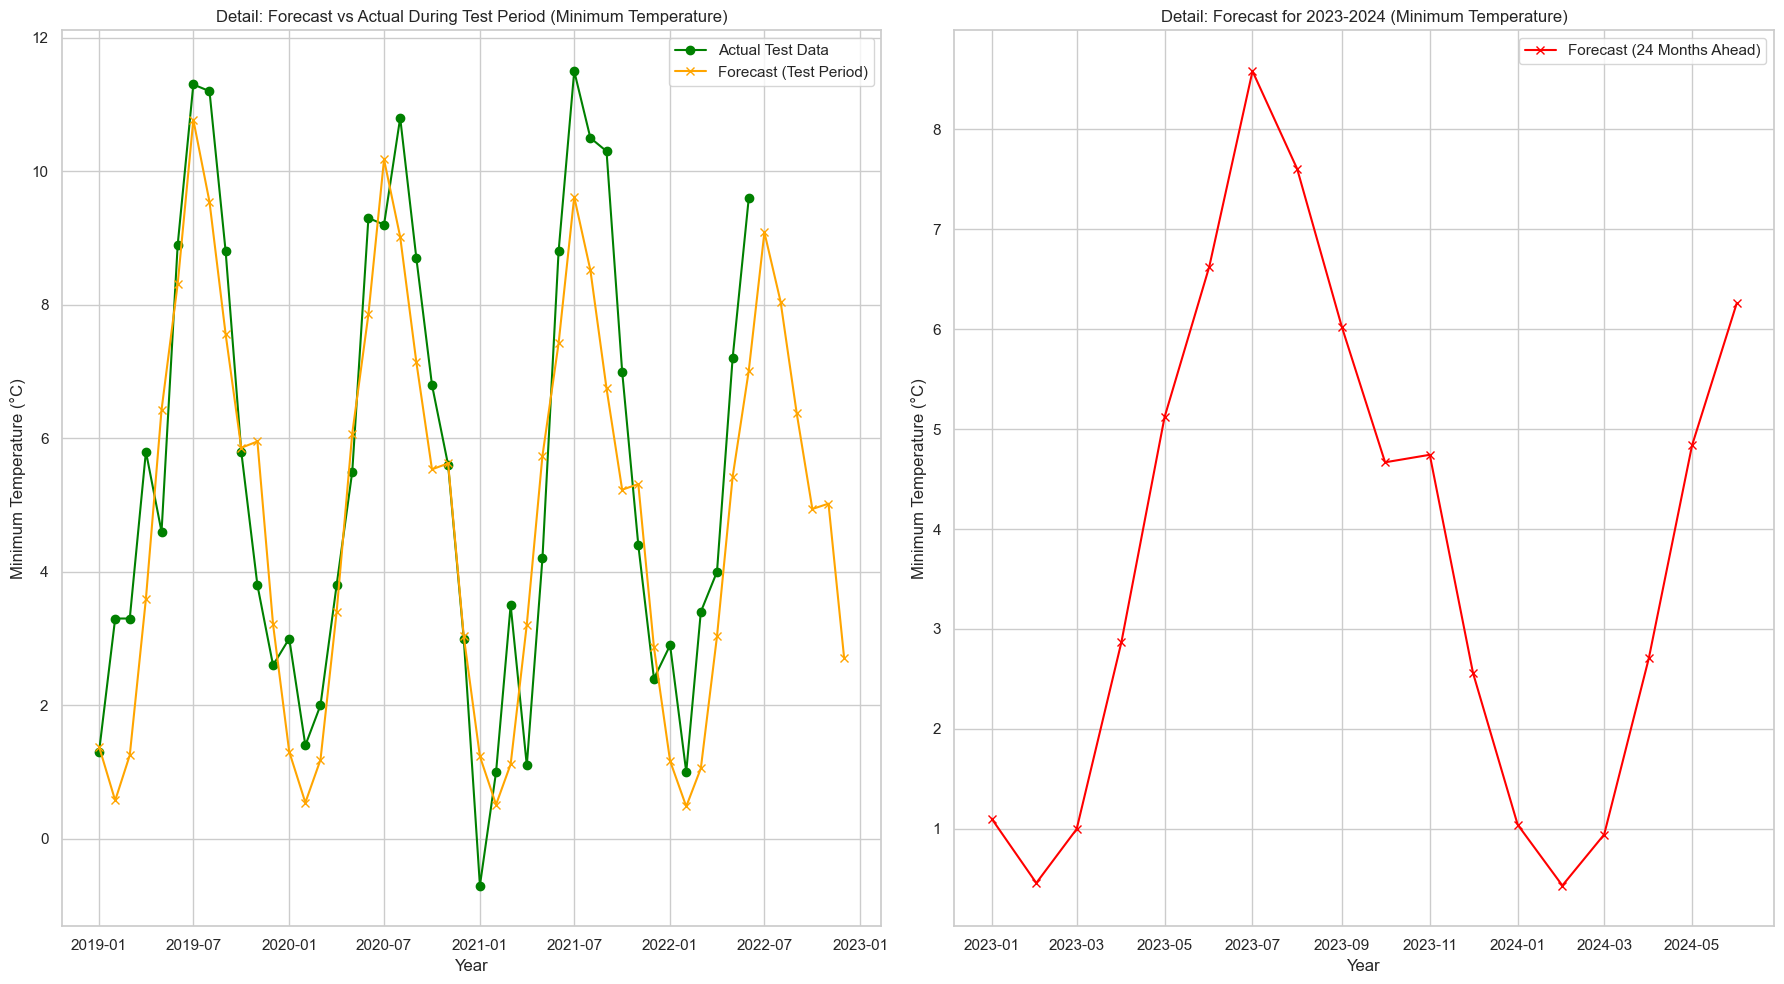

Forecast Accuracy Metrics (Minimum Temperature):
            MAE      RMSE       MAPE
Value  1.368553  1.595932  39.026731


c:\Users\Owen\miniconda3\envs\ea_cs\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


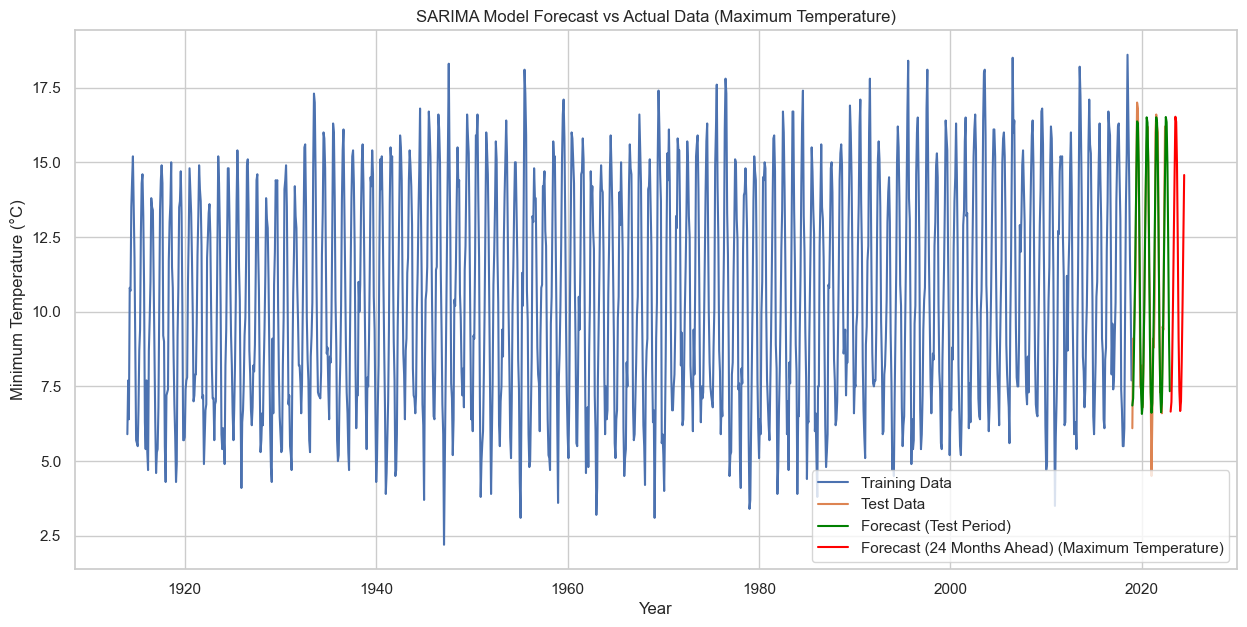

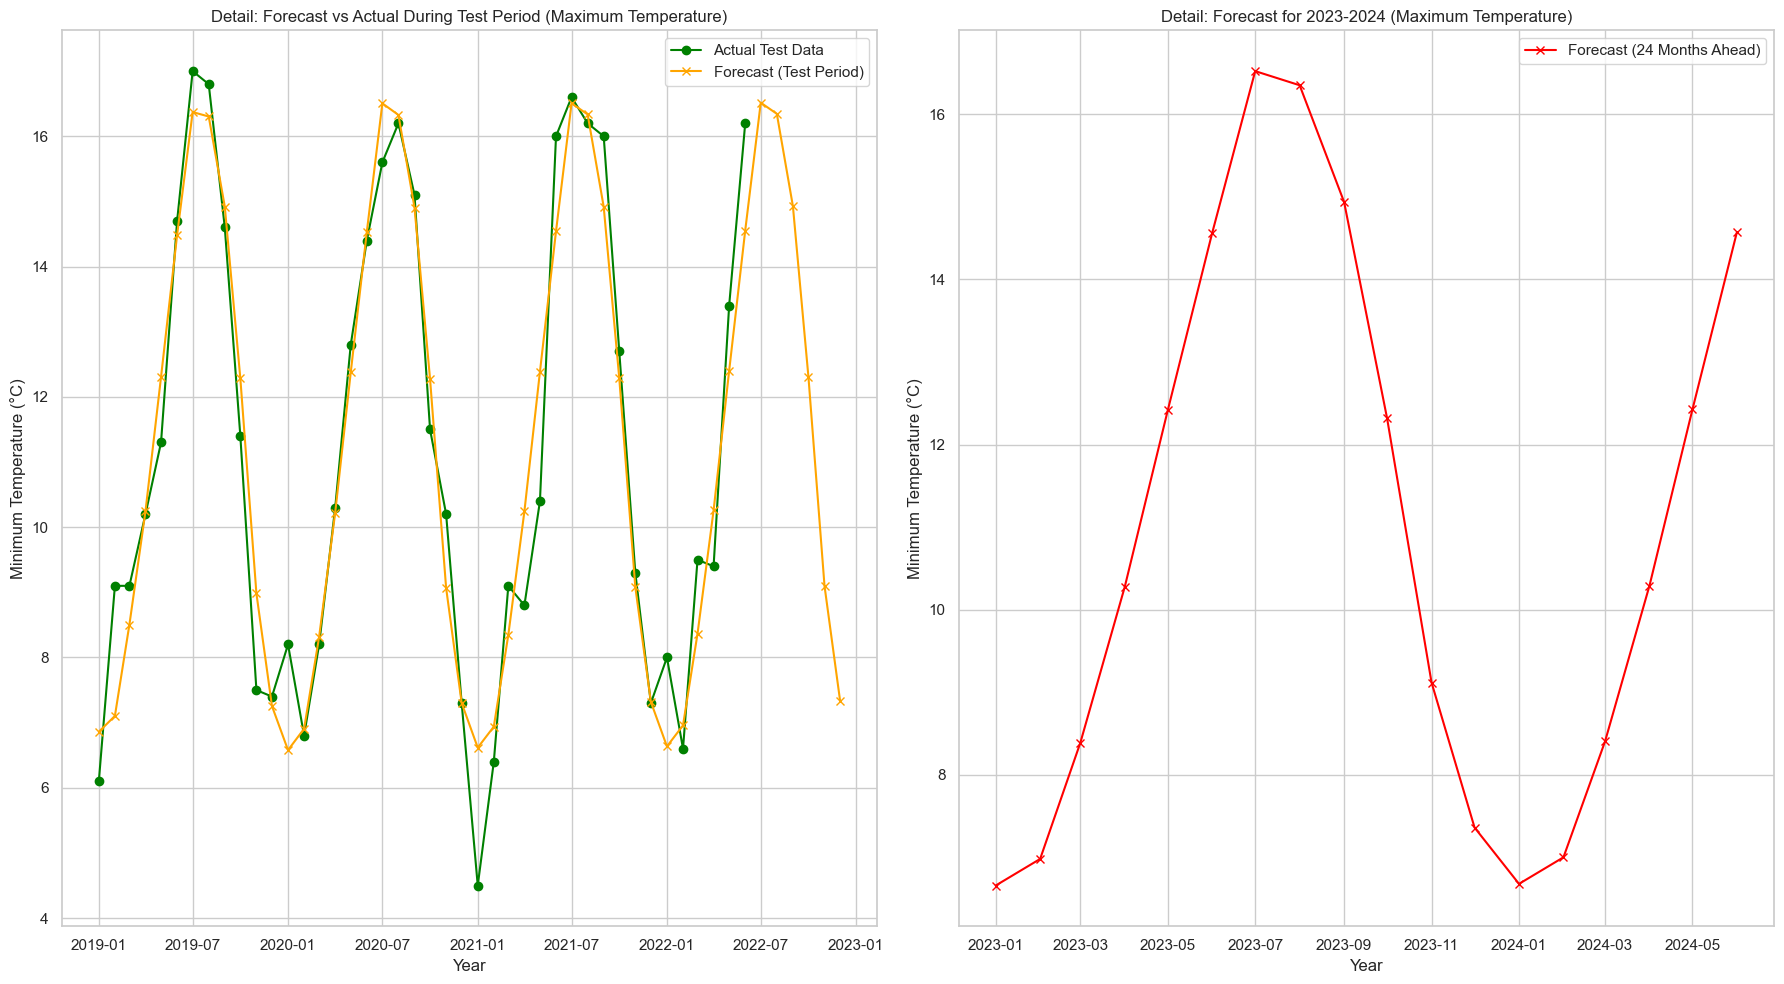

Forecast Accuracy Metrics (Maximum Temperature):
            MAE      RMSE      MAPE
Value  0.733525  0.950811  7.788071


In [100]:
"""Due to clear seasonality shown from ADF tests, we used a SARIMA model, which is well-suited for time series data that exhibits seasonal patterns.
"""


from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Filling any missing data points with interpolation before modeling
def sarima_modelling(column_name, find_optimum_parameters=False):
    def identify_optimal_sarima_parameters(df_series):
        sarima_model = auto_arima(df_series, seasonal=True, m=12, trace=True,
                            error_action='ignore', suppress_warnings=True,
                            stepwise=True, n_fits=50)

        sarima_model.summary()

        # Extract the optimal model order and seasonal order
        optimal_order = sarima_model.order
        optimal_seasonal_order = sarima_model.seasonal_order

        return (optimal_order, optimal_seasonal_order)


    # Define training and testing sets
    def train_test_split_custom(df_series, train_end_year, test_end_year):
        df_series.index = pd.date_range(start=df_series.index[0], periods=len(df_series), freq='MS')
        
        train_data = df_series[:str(train_end_year)]
        test_data = df_series[str(train_end_year + 1):str(test_end_year)]
        return train_data,test_data

    # Fit the SARIMA model
    def fit_sarima(train_data, optimal_order = (1, 0, 0), optimal_seasonal_order = (1, 0, 0, 12)):
        model = SARIMAX(train_data, order=optimal_order, seasonal_order=optimal_seasonal_order, freq = "MS")
        sarima_result = model.fit(disp=False)
        return sarima_result

    def forecast_sarima(sarima_result, test_data, months):
        # Retrieve the first and last date in the test data
        first_date_in_test_data = test_data.index[0]
        last_date_in_test_data = test_data.index[-1]

        # Determine the total number of steps to forecast from the first date in test data
        # This includes the duration of the test data plus additional months
        total_months = (last_date_in_test_data.year - first_date_in_test_data.year) * 12 + \
                    (last_date_in_test_data.month - first_date_in_test_data.month + 1) + months

        # Generate the forecast from the first date of test data
        forecast = sarima_result.get_forecast(steps=total_months)

        # Create a forecast index starting from the first date in the test data
        forecast_index = pd.date_range(first_date_in_test_data, periods=total_months, freq='MS')

        return forecast, forecast_index


    # Visualizing the results with historical data, test data, and forecast
    def plot_forecast(train_data, test_data, forecast_series, forecasting_months):
        plt.figure(figsize=(15, 7))
        plt.plot(train_data, label='Training Data')
        plt.plot(test_data, label='Test Data')
        plt.plot(forecast_series['2019':'2022'], label='Forecast (Test Period)', color='green')
        plt.plot(forecast_series['2023':'2024'], label=f'Forecast ({forecasting_months} Months Ahead) ({column_name_taxonomy[column_name]})', color='red')
        plt.title(f'SARIMA Model Forecast vs Actual Data ({column_name_taxonomy[column_name]})')
        plt.xlabel('Year')
        plt.ylabel('Minimum Temperature (°C)')
        plt.legend()
        plt.show()
    

    def plot_detailed_forecast(train_data, test_data, forecast_series, forecasting_months):
        plt.figure(figsize=(18, 10))

        # Subplot 1: Test Data vs Forecast (Test Period)
        plt.subplot(1, 2, 1)
        test_period_end_year = test_data.index[-1].year
        plt.plot(test_data, label='Actual Test Data', color='green', marker='o')
        plt.plot(forecast_series[:str(test_period_end_year)], label='Forecast (Test Period)', color='orange', marker='x')
        plt.title(f'Detail: Forecast vs Actual During Test Period ({column_name_taxonomy[column_name]})')
        plt.xlabel('Year')
        plt.ylabel('Minimum Temperature (°C)')
        plt.legend()

        # Subplot 2: Forecast for the Next 24 Months
        plt.subplot(1, 2, 2)
        forecast_future_start = str(test_period_end_year + 1)
        forecast_future_end = str(test_period_end_year + 2)
        plt.plot(forecast_series[forecast_future_start:forecast_future_end], label=f'Forecast ({forecasting_months} Months Ahead)', color='red', marker='x')
        plt.title(f'Detail: Forecast for {forecast_future_start}-{forecast_future_end} ({column_name_taxonomy[column_name]})')
        plt.xlabel('Year')
        plt.ylabel('Minimum Temperature (°C)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def calculate_forecast_accuracy_metrics(test_data, forecast_data):
        """
        Calculate forecast accuracy metrics.
        """

        forecast_data = forecast_data[test_data.index[0]:test_data.index[-1]]
        mae = mean_absolute_error(test_data, forecast_data)
        rmse = np.sqrt(mean_squared_error(test_data, forecast_data))
        mape = np.mean(np.abs(test_data - forecast_data) / np.abs(test_data)) * 100
        
        metrics = pd.DataFrame({
            "MAE": [mae],
            "RMSE": [rmse],
            "MAPE": [mape]
        }, index=["Value"])
        
        return metrics


    wick_airport_data[column_name] = wick_airport_data[column_name].interpolate(method='time')

    train_end_year = 2018
    test_end_year = 2022
    train_data, test_data = train_test_split_custom(wick_airport_data[column_name], train_end_year=train_end_year, test_end_year = test_end_year)

    # Using auto_arima to find the best SARIMA model parameters
    if find_optimum_parameters:
        optimal_order, optimal_seasonal_order = identify_optimal_sarima_parameters(wick_airport_data[column_name])
        sarima_result = fit_sarima(train_data, optimal_order= optimal_order, optimal_seasonal_order = optimal_seasonal_order)
    else:
       stored_optimum_results = {
            "tmin": {
                "order": (1, 0, 0),
                "seasonal_order": (1, 0, 0, 12)
            },
            "tmax": {
                "order": (3, 1, 1),
            "seasonal_order": (2, 0, 1, 12),
            }
        }
       
       sarima_result = fit_sarima(train_data, stored_optimum_results[column_name]["order"], stored_optimum_results[column_name]["seasonal_order"])

    forecasting_months = 24
    forecast, forecast_index = forecast_sarima(sarima_result, test_data, forecasting_months)  


    # Create a series for forecasted values
    forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

    plot_forecast(train_data, test_data, forecast_series, forecasting_months)
    plot_detailed_forecast(train_data, test_data, forecast_series, forecasting_months)

    # Calculate forecast accuracy metrics
    forecast_metrics = calculate_forecast_accuracy_metrics(test_data, forecast_series)
    print(f"Forecast Accuracy Metrics ({column_name_taxonomy[column_name]}):")
    print(forecast_metrics)

sarima_modelling(column_name="tmin", find_optimum_parameters=False)
sarima_modelling(column_name="tmax", find_optimum_parameters=False)